### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 28 мая 2022, 08:30   
**Штраф за опоздание:** по 1 баллу за 24 часа задержки.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [638]:
def gini(left, right, initial):
    count_l = np.unique(left, return_counts = True)[1]
    count_r = np.unique(right, return_counts = True)[1]
    count_i = np.unique(initial, return_counts = True)[1]
    
    p_l = count_l/count_l.sum()
    p_r = count_r/count_r.sum()
    p_i = count_i/count_i.sum()
    
    g_l = 1 - (p_l ** 2).sum()
    g_r = 1 - (p_r ** 2).sum()
    g_i = 1 - (p_i ** 2).sum()
    
    return g_i - (count_l.sum() * g_l + count_r.sum() * g_r) / count_i.sum()  

In [641]:
def entropy(left, right, initial):
    count_l = np.unique(left, return_counts = True)[1]
    count_r = np.unique(right, return_counts = True)[1]
    count_i = np.unique(initial, return_counts = True)[1]
    
    p_l = count_l/count_l.sum()
    p_r = count_r/count_r.sum()
    p_i = count_i/count_i.sum()
    
    s_l = (-p_l*np.log2(p_l)).sum()
    s_r = (-p_r*np.log2(p_r)).sum()
    s_i = (-p_i*np.log2(p_i)).sum()
    
    return s_i - (count_l.sum() * s_l + count_r.sum() * s_r) / count_i.sum()

In [642]:
def classification_error(left, right, initial):
    count_l = np.unique(left, return_counts = True)[1]
    count_r = np.unique(right, return_counts = True)[1]
    count_i = np.unique(initial, return_counts = True)[1]
    
    p_l = count_l/count_l.sum()
    p_r = count_r/count_r.sum()
    p_i = count_i/count_i.sum()
    
    m_l = 1 - np.max(p_l)
    m_r = 1 - np.max(p_r)
    m_i = 1 - np.max(p_i)
    
    return m_i - (count_l.sum() * m_l + count_r.sum() * m_r) / count_i.sum()

In [632]:
def func(a):
#     p_l = np.bincount(a[0:i])/np.bincount(a[0:i]).sum() for i in range(1, len(a))
#     p_r =np.bincount(a[i:])/np.bincount(a[i:]).sum() for i in range(len(a) - 1)
#     count = np.bincount(a)/np.bincount(a).sum()
    return [gini(a[0:i], a[i:]) for i in range(1, len(a))]
    

In [730]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = dict()
        if criterion =='gini':
            self.criterion = gini
        elif criterion =='entropy':
            self.criterion = entropy
        else:
            self.criterion = classification_error
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
    
    def func(self, a):
        return [self.criterion(a[0:i], a[i:], a) for i in range(1, len(a))]

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        
#         crit = 0
#         feature_index = 0
#         value = x[:,0]
#         for i in range(x.shape[1]):
#             for feature in np.unique(x[:,]):
#                 x_left, x_right, y_left, y_right = self.__div_samples(x, y, i, feature)
#                 if len(y_left) and len(y_right):
#                     new_crit = self.criterion(y_left, y_right, self.num_class)
#                     if crit < new_crit:
#                         crit = new_crit
#                         feature_index = i
#                         value = feature
#         return feature_index, value

#         crit = 0
#         feature_index = 0
#         value = x[:,0]
        
#         count = np.bincount(y)
#         p = count/count.sum()
#         crit_0 = self.criterion(p)
        
#         for i in range(x.shape[1]):
#             for feature in np.unique(x[:,]):
#                 x_left, x_right, y_left, y_right = self.__div_samples(x, y, i, feature)
#                 if len(y_left) and len(y_right):
#                     count_l = np.bincount(y_left)
#                     count_r = np.bincount(y_right)
#                     p_l = count_l/count_l.sum()
#                     p_r = count_r/count_r.sum()
#                     crit_1 = self.criterion(p_l)
#                     crit_2 = self.criterion(p_r)
#                     new_crit = crit_0 - (count_l.sum() * crit_1 + count_r.sum() * crit_2) / count.sum()
                    
#                     if crit < new_crit:
#                         crit = new_crit
#                         feature_index = i
#                         value = feature
#         return feature_index, value


        x_sorted = np.sort(x.T, axis = 1)
        y_sorted = (y[x.T.argsort(axis = 1)]).astype(int)
        crit = np.apply_along_axis(self.func, 1, y_sorted)
        maxim = np.max(crit)
        mask = crit == maxim
        x_small = x_sorted[:,1:]
        therehold = x_small[mask][0]
        feature_index = np.where(mask == True)[0][0]
        self.feature_importances_[feature_index] = self.feature_importances_.setdefault(feature_index, 0)  + therehold
        
        return feature_index, therehold

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if x.shape[0] == 0:
            pass
        elif depth == self.max_depth or np.unique(y).size <= 1 or y.size < self.min_samples_split:
            uniq = np.unique(y, return_counts=True)
            self.tree[node_id] = (self.LEAF_TYPE, uniq[0][np.argmax(uniq[1])], uniq[0].size/uniq[1].sum())
        else: 
            feature, threshold = self.__find_threshold(x, y)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature, threshold)
            if y_left.size > 0 and y_right.size > 0:
                self.tree[node_id] = (self.NON_LEAF_TYPE, feature, threshold)

                self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
                self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)

            else:
                uniq = np.unique(y, return_counts=True)
                self.tree[node_id] = (self.LEAF_TYPE, uniq[0][np.argmax(uniq[1])], uniq[0].size/uniq[1].sum())
        
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [712]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [713]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [714]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [715]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


In [716]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=3)
my_clf.fit(X_train, y_train)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=8)
my_clf.fit(X_train, y_train)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=30)
my_clf.fit(X_train, y_train)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444
0.9444444444444444


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [653]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


DecisionTreeClassifier()

In [654]:
%time my_clf.fit(X_train, y_train)

Wall time: 1.66 s


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [365]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')

In [366]:
df.shape

(8378, 195)

In [367]:
df

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,22.0,1,44,2,21,22,14,10.0,5,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0


In [368]:
df = df.iloc[:, :97]

In [369]:
df.iid.nunique()

551

In [370]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

In [371]:
df.drop_duplicates(subset=['iid']).gender.value_counts()

1    277
0    274
Name: gender, dtype: int64

In [372]:
df.drop_duplicates(subset=['iid']).condtn.value_counts()

2    386
1    165
Name: condtn, dtype: int64

In [373]:
df = df.drop(['condtn'], axis=1)

In [374]:
df.wave.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21], dtype=int64)

In [375]:
df = df.drop(['round'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)

In [376]:
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

<AxesSubplot:>

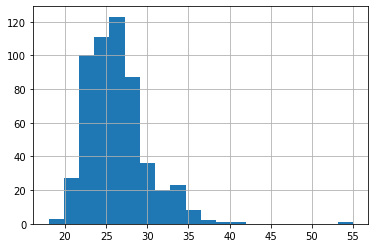

In [377]:
df.drop_duplicates(subset=['iid']).age.hist(bins=20)

In [378]:
df.drop_duplicates('iid').age.isnull().sum()

8

In [379]:
df = df.dropna(subset=['age'])

In [380]:
for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())

Field Code 1.0
['Law' 'law' 'LAW' 'Law and Social Work'
 'Law and English Literature (J.D./Ph.D.)' 'Intellectual Property Law'
 'Law/Business']
Field Code 2.0
['Economics' 'Mathematics' 'Statistics' 'math' 'Mathematics, PhD' 'Stats'
 'math of finance' 'Math']
Field Code 3.0
['Psychology' 'Speech Language Pathology' 'Speech Languahe Pathology'
 'Educational Psychology' 'Organizational Psychology' 'psychology'
 'Communications' 'Sociology' 'psychology and english' 'theory'
 'Health policy' 'Clinical Psychology' 'Sociology and Education'
 'sociology' 'Anthropology/Education' 'speech pathology'
 'Speech Pathology' 'Anthropology' 'School Psychology' 'anthropology'
 'Counseling Psychology' 'African-American Studies/History']
Field Code 4.0
['Medicine' 'Art History/medicine'
 'Sociomedical Sciences- School of Public Health' 'Epidemiology'
 'GS Postbacc PreMed' 'medicine']
Field Code 5.0
['Operations Research' 'Mechanical Engineering' 'Engineering'
 'Electrical Engineering' 'Operations Researc

In [381]:
df.field_cd.isnull().sum()

19

In [382]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)

In [383]:
df = df.drop(['field'], axis=1)

In [384]:
from sklearn.preprocessing import OneHotEncoder
coder = OneHotEncoder()
non_cat = coder.fit_transform(df['field_cd'].values.reshape(-1,1)).toarray()
s='field_'
for i in range(non_cat.T.shape[0]):
    df[s+str(i+1)] = non_cat.T[i]

In [385]:
df.undergra.value_counts().head()

UC Berkeley    107
Harvard        104
Columbia        95
Yale            86
NYU             78
Name: undergra, dtype: int64

In [386]:
df = df.drop(['undergra'], axis=1)

In [387]:
df.mn_sat.value_counts().head()

1,400.00    403
1,430.00    262
1,290.00    190
1,450.00    163
1,340.00    146
Name: mn_sat, dtype: int64

C:\Users\masha\AppData\Local\Temp/ipykernel_6528/831134450.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)


342

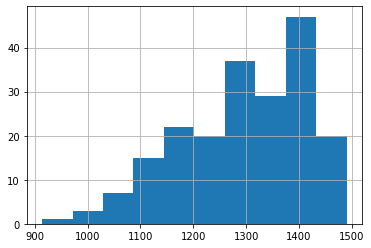

In [388]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').mn_sat.hist()
df.drop_duplicates('iid').mn_sat.isnull().sum()

In [389]:
df.tuition.value_counts().head()

26,908.00    241
26,019.00    174
15,162.00    138
25,380.00    112
26,062.00    108
Name: tuition, dtype: int64

In [390]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

C:\Users\masha\AppData\Local\Temp/ipykernel_6528/2792761991.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)


310

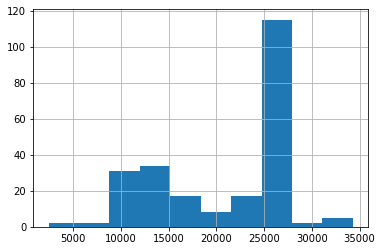

In [391]:
df.drop_duplicates('iid').tuition.hist()
df.drop_duplicates('iid').tuition.isnull().sum()

In [392]:
df.drop_duplicates('iid').imprace.isnull().sum()
df.drop_duplicates('iid').imprelig.isnull().sum()
df = df.dropna(subset=['imprelig', 'imprace'])

In [393]:
df = df.drop(['from', 'zipcode'], axis=1)

C:\Users\masha\AppData\Local\Temp/ipykernel_6528/3501697013.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)


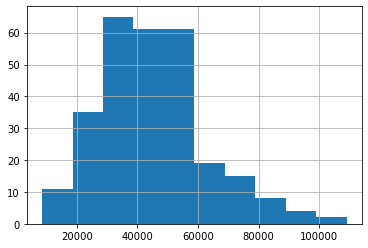

In [394]:
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').loc[:, 'income'].hist()
df.drop_duplicates('iid').loc[:, 'income'].isnull().sum()
df = df.drop(['income'], axis=1)

In [395]:
df = df.dropna(subset=['date'])

In [396]:
for i, group in df.groupby('career_c'):
    print('=' * 10)
    print('Career Code {}'.format(i))
    print(group.career.unique())
df.career_c.isnull().sum()
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df = df.drop(['career'], axis=1)

Career Code 1.0
['lawyer/policy work' 'lawyer' 'Law' 'Corporate Lawyer' 'Lawyer'
 'Corporate attorney' 'law' 'Intellectual Property Attorney' 'LAWYER'
 'attorney' 'Lawyer or professional surfer' 'lawyer/gov.position'
 'Law or finance' 'IP Law' 'Academic (Law)' 'Private Equity' 'attorney?'
 'Corporate law' 'tax lawyer' 'Business/Law' 'Assistant District Attorney']
Career Code 2.0
['Academia, Research, Banking, Life' 'academics or journalism' 'Professor'
 'Academic' 'academia' 'teacher' 'industrial scientist'
 'teaching and then...' 'Professor of Media Studies'
 'Education Administration' 'Academic or Research staff'
 'University Professor' 'Research Scientist'
 'research in industry or academia' 'Teacher/Professor'
 'no idea, maybe a professor' 'a research position' 'professor' 'teaching'
 'engineering professional' 'research' 'Neuroscientist/Professor'
 'Education' 'Professor and Government Official'
 'physicist, probably academia' 'college art teacher' 'academic'
 'Research scientist,

In [397]:
coder = OneHotEncoder()

non_cat = coder.fit_transform(df['career_c'].values.reshape(-1,1)).toarray()

s='career_'
for i in range(non_cat.T.shape[0]):
    df[s+str(i+1)] = non_cat.T[i]

In [398]:
df = df.drop('career_c', axis=1)

In [399]:
df.loc[:, ['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
      ].isnull().sum()

sports      0
tvsports    0
exercise    0
dining      0
museums     0
art         0
hiking      0
gaming      0
clubbing    0
reading     0
tv          0
theater     0
movies      0
concerts    0
music       0
shopping    0
yoga        0
dtype: int64

In [400]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

In [401]:
df.drop_duplicates('iid').exphappy.isnull().sum()
df.drop_duplicates('iid').expnum.isnull().sum()
df = df.drop(['expnum'], axis=1)

In [402]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]

,iid,wave,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,totalsum
1846,132,6,16.67,16.67,16.67,16.67,16.67,16.67,100.02
1851,133,6,12.77,19.15,17.02,17.02,14.89,19.15,100.00
1856,134,6,6.67,20.00,20.00,17.78,20.00,15.56,100.01
1861,135,6,18.18,22.73,18.18,13.64,13.64,13.64,100.01
1871,137,6,17.39,17.39,15.22,17.39,13.04,19.57,100.00
...,...,...,...,...,...,...,...,...,...
3308,229,9,21.43,16.67,21.43,16.67,11.90,11.90,100.00
3328,230,9,23.81,23.81,23.81,23.81,2.38,2.38,100.00
3348,231,9,18.60,20.93,23.26,23.26,2.33,11.63,100.01
3368,232,9,17.78,17.78,17.78,17.78,13.33,15.56,100.01


In [403]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [404]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)

In [405]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

In [406]:
df = df.drop(['wave'], axis=1)

In [408]:
df = df.drop(['mn_sat', 'tuition'], axis=1)

In [532]:
df

,iid,gender,pid,match,int_corr,samerace,age,field_cd,race,imprace,...,career_9,career_10,career_11,career_12,career_13,career_14,career_15,career_16,career_17,career_18
0,1,0,11.0,0,0.14,0,21.0,1.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,12.0,0,0.54,0,21.0,1.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0,13.0,1,0.16,1,21.0,1.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,14.0,1,0.61,0,21.0,1.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0,15.0,1,0.21,0,21.0,1.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,526.0,0,0.64,0,25.0,18.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8374,552,1,527.0,0,0.71,0,25.0,18.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8375,552,1,528.0,0,-0.46,0,25.0,18.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8376,552,1,529.0,0,0.62,0,25.0,18.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [717]:
y_data = np.array(df['match'])
X_data = np.array(df.drop(['match'], axis=1))

In [718]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1)

In [719]:
kfold = KFold(n_splits = 3, shuffle = True)

In [720]:
criterion = ['gini', 'entropy', 'classification_error']

In [721]:
import tqdm

In [660]:
middle = []
for crt in tqdm.tqdm(criterion):
    my_clf = MyDecisionTreeClassifier(min_samples_split=10, criterion=crt)
    res = 0
    for ind_train, ind_test in tqdm.tqdm(kfold.split(X_train, y_train)):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        
        my_clf.fit(X_train_, y_train_)
        res += accuracy_score(y_pred=my_clf.predict(X_test_), y_true=y_test_)
        
    middle.append(res / 3)
    print(res/3)

print(middle)
best_crit= criterion[np.argmax(middle)]   

print("Лучший критерий =", best_crit)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [04:19, 259.49s/it]
2it [09:29, 288.96s/it]
3it [18:44, 374.77s/it]
 33%|███████████████████████████▎                                                      | 1/3 [18:44<37:28, 1124.31s/it]

0.8364756702024284



0it [00:00, ?it/s]
1it [04:12, 252.40s/it]
2it [12:36, 400.21s/it]
3it [16:54, 338.29s/it]
 67%|██████████████████████████████████████████████████████▋                           | 2/3 [35:39<17:39, 1059.93s/it]

0.8370144996175716



0it [00:00, ?it/s]
1it [01:18, 78.62s/it]
2it [06:08, 202.65s/it]
3it [08:45, 175.01s/it]
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [44:24<00:00, 888.07s/it]

0.8372835876958754
[0.8364756702024284, 0.8370144996175716, 0.8372835876958754]
Лучший критерий = classification_error


In [722]:
accuracy_dpt = []
for dpt in tqdm.tqdm(range(1, 11)):
    my_clf = MyDecisionTreeClassifier(min_samples_split=10, max_depth=dpt, criterion=best_crit)
    my_clf.fit(X_train, y_train)
    acc = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    print(acc)
    accuracy_dpt.append(acc)
print(accuracy_dpt)

 10%|████████▏                                                                         | 1/10 [02:28<22:20, 148.98s/it]

0.8412121212121212


 20%|████████████████▍                                                                 | 2/10 [04:50<19:17, 144.63s/it]

0.8412121212121212


 30%|████████████████████████▌                                                         | 3/10 [07:13<16:46, 143.80s/it]

0.8412121212121212


 40%|████████████████████████████████▊                                                 | 4/10 [09:37<14:23, 144.00s/it]

0.8412121212121212


 50%|█████████████████████████████████████████                                         | 5/10 [12:14<12:23, 148.62s/it]

0.8412121212121212


 60%|█████████████████████████████████████████████████▏                                | 6/10 [14:54<10:10, 152.51s/it]

0.8412121212121212


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [17:30<07:40, 153.49s/it]

0.8412121212121212


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [20:02<05:06, 153.11s/it]

0.8412121212121212


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [22:44<02:35, 155.99s/it]

0.8412121212121212


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [25:26<00:00, 152.70s/it]

0.8412121212121212
[0.8412121212121212, 0.8412121212121212, 0.8412121212121212, 0.8412121212121212, 0.8412121212121212, 0.8412121212121212, 0.8412121212121212, 0.8412121212121212, 0.8412121212121212, 0.8412121212121212]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


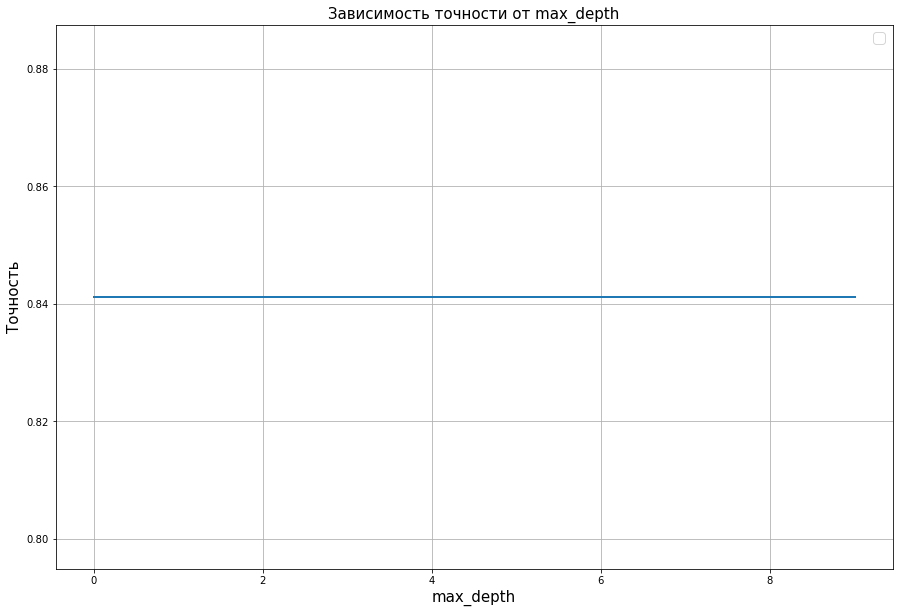

In [723]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от max_depth', fontsize=15)
plt.xlabel('max_depth', fontsize=15)
plt.ylabel('Точность', fontsize=15)
plt.plot( accuracy_dpt, linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

In [724]:
accuracy_mss = []
for mss in range(1, 20, 2):
    my_clf = MyDecisionTreeClassifier(min_samples_split=mss, criterion=best_crit)
    my_clf.fit(X_train, y_train)
    acc = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    accuracy_mss.append(acc)
    print(acc)
print(accuracy_mss)

0.8412121212121212
0.8412121212121212
0.8412121212121212
0.8412121212121212
0.8412121212121212


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


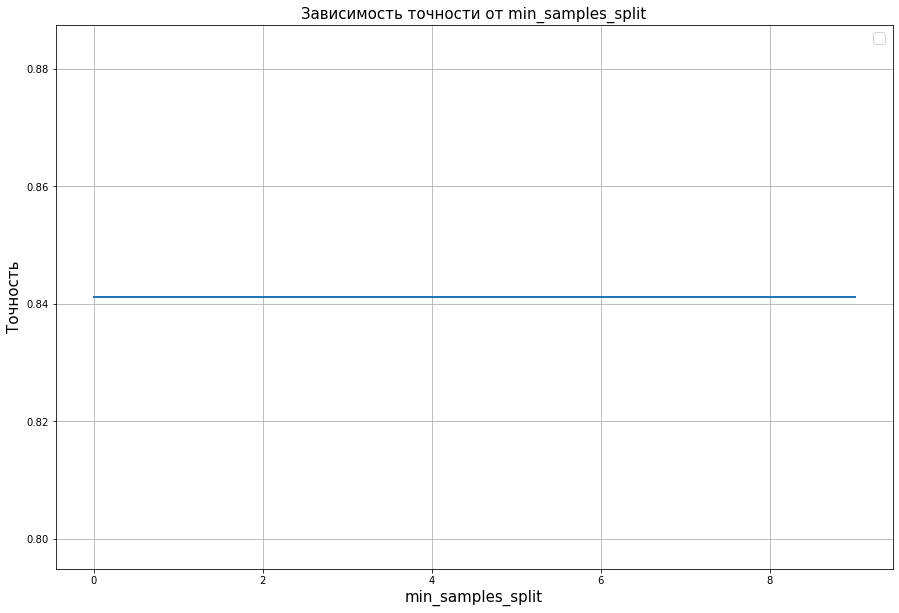

In [725]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от min_samples_split', fontsize=15)
plt.xlabel('min_samples_split', fontsize=15)
plt.ylabel('Точность', fontsize=15)
plt.plot( accuracy_dpt, linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [732]:
my_clf = MyDecisionTreeClassifier(min_samples_split=10)
my_clf.fit(X_train, y_train)

In [733]:
my_clf.get_feature_importance()

{19: 10.0, 2: 18.0, 8: 5.0, 33: 1.0, 34: 1.0, 10: 2.0, 4: 1.0, 9: 1.0, 30: nan}

In [741]:
val = np.array(list(my_clf.get_feature_importance().values()))
index = np.argsort(val)[::-1]


In [742]:
for feat in df.drop(['match'], axis=1).columns[index].values:
    print(feat)

imprace
gender
iid
pid
age
race
field_cd
samerace
int_corr


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Я запуталась и не поняла из-за чего у меня получились такие графики в конце, я долго искала ошибку и даже успела опробовать несколько споробов нахождения оптимального деления, хотя они и не оказались достаточно быстрыми